# imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# helper

In [28]:
# Define the neural network for the PINN with an additional bloom threshold output
class BloomPINN(nn.Module):
    def __init__(self, n_hidden_layers=3, n_neurons=20):
        super(BloomPINN, self).__init__()
        layers = []
        layers.append(nn.Linear(1, n_neurons))  # Input layer (time)
        layers.append(nn.Tanh())
        for _ in range(n_hidden_layers):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(n_neurons, 2))  # Output layer: [cumulative GDD, bloom threshold]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Calculate daily GDD and cumulative GDD
def calculate_gdd(temp, base_temp):
    return torch.clamp(temp - base_temp, min=0)

# Define the residual function including the bloom threshold
def bloom_residual(model, t, temp, gdd_bloom_actual):
    pred_gdd, pred_bloom_threshold = model(t).chunk(2, dim=1)
    gdd_actual = calculate_gdd(temp, base_temperature)
    cumulative_gdd = torch.cumsum(gdd_actual, dim=0)
    residual_gdd = pred_gdd - cumulative_gdd
    residual_bloom = pred_bloom_threshold - gdd_bloom_actual
    return residual_gdd, residual_bloom

# Generate synthetic training data for simplicity
def generate_bloom_data(n_samples=100):
    t = np.linspace(0, 100, n_samples)
    temp = 15 + 10 * np.sin(2 * np.pi * t / 365)  # Simulated temperature data
    gdd_bloom_actual = np.cumsum(np.maximum(temp - base_temperature, 0)).max()  # Actual GDD at bloom
    return torch.tensor(t, dtype=torch.float32).view(-1, 1), torch.tensor(temp, dtype=torch.float32).view(-1, 1), torch.tensor(gdd_bloom_actual, dtype=torch.float32).view(1, 1)

# Training the model with bloom prediction
def train_bloom_pinn(model, t_train, temp_train, gdd_bloom_actual, n_epochs=20000, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()

        residual_gdd, residual_bloom = bloom_residual(model, t_train, temp_train, gdd_bloom_actual)
        loss_gdd = loss_fn(residual_gdd, torch.zeros_like(residual_gdd))
        loss_bloom = loss_fn(residual_bloom, torch.zeros_like(residual_bloom))
        loss = loss_gdd + loss_bloom

        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss.item()}, Bloom Loss: {loss_bloom.item()}')

# pinn

In [27]:
# Define the GDD parameters
base_temperature = 10  # Example base temperature in Celsius

# Define the model and check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## data

In [ ]:
# Generate data and move to the same device
t_train, temp_train, gdd_bloom_actual = generate_bloom_data()
t_train = t_train.to(device)
temp_train = temp_train.to(device)
gdd_bloom_actual = gdd_bloom_actual.to(device)

## model


In [ ]:
# Create and move model to the appropriate device
model = BloomPINN(n_hidden_layers=3, n_neurons=20).to(device)


## train

In [ ]:

# Train the model
train_bloom_pinn(model, t_train, temp_train, gdd_bloom_actual)



## eval

In [31]:
# Evaluate and visualize the results
model.eval()
with torch.no_grad():
    # Predict GDD and bloom threshold
    pred_gdd, pred_bloom_threshold = model(t_train).chunk(2, dim=1)
    gdd_actual = calculate_gdd(temp_train, base_temperature)
    cumulative_gdd_actual = torch.cumsum(gdd_actual, dim=0)

    # Convert to numpy for plotting
    t_plot = t_train.cpu().numpy()
    pred_gdd = pred_gdd.cpu().numpy()
    pred_bloom_threshold = pred_bloom_threshold.cpu().numpy()
    cumulative_gdd_actual = cumulative_gdd_actual.cpu().numpy()
    gdd_bloom_actual = gdd_bloom_actual.cpu().numpy()

print("Done.")

NameError: name 'model' is not defined

## plot

In [32]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot cumulative GDD over time
plt.plot(t_plot, cumulative_gdd_actual, label='Actual Cumulative GDD', color='green')
plt.plot(t_plot, pred_gdd, label='Predicted Cumulative GDD', linestyle='--', color='blue')

# Mark the actual and predicted bloom thresholds
plt.axhline(y=gdd_bloom_actual, color='red', linestyle='-', label='Actual Bloom Threshold')
plt.axhline(y=pred_bloom_threshold[-1], color='orange', linestyle='--', label='Predicted Bloom Threshold')

# Labels and legend
plt.xlabel('Time (days)')
plt.ylabel('Growing Degree Days (GDD)')
plt.title('PINN Prediction of Cumulative GDD and Bloom Threshold')
plt.legend()
# plt.savefig('bloom_pinn_results.png')
plt.show()

NameError: name 't_plot' is not defined

<Figure size 720x432 with 0 Axes>

# Random forest

## data

In [21]:
# 1. Generate random input data (X) and target (y)
np.random.seed(42)
n_samples = 1000
n_features = 5  # Number of input features

# features
features = np.random.rand(n_samples, n_features)  # Random inputs between 0 and 1

# peak bloom day of the year label
label_peak = np.sum(features**2, axis=1) + 0.1 * np.random.randn(n_samples)  # Quadratic target + noise

# 2. Split the dataset
features_train, features_test, label_peak_train, label_peak_test = train_test_split(features, label_peak, test_size=0.2, random_state=42)


## model

In [29]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

## train

In [30]:
# 3. Train the Random Forest Regressor
rf.fit(features_train, label_peak_train)

RandomForestRegressor(random_state=42)

## eval

In [23]:
# 4. Evaluate the model
label_peak_pred = rf.predict(features_test)
mse = mean_squared_error(label_peak_test, label_peak_pred)
print("Mean Squared Error:", mse)



Mean Squared Error: 0.04111296825566016


## plot

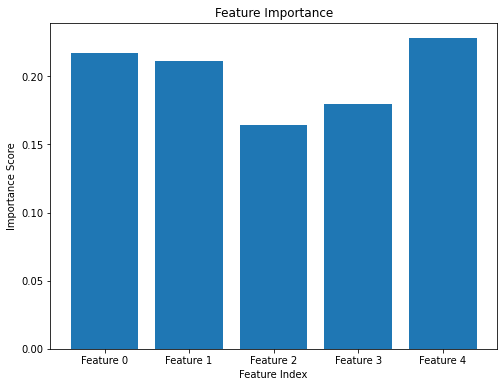

In [24]:
# 5. Get feature importance
feature_importance = rf.feature_importances_

# 6. Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(range(n_features), feature_importance, tick_label=[f'Feature {i}' for i in range(n_features)])
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()